--- SparkSession Created ---
--- Base DataFrame Prepared ---
--- Feature Engineering Complete ---
--- Model Trained and Predictions Made ---

--- Generating Confusion Matrix Heatmap ---


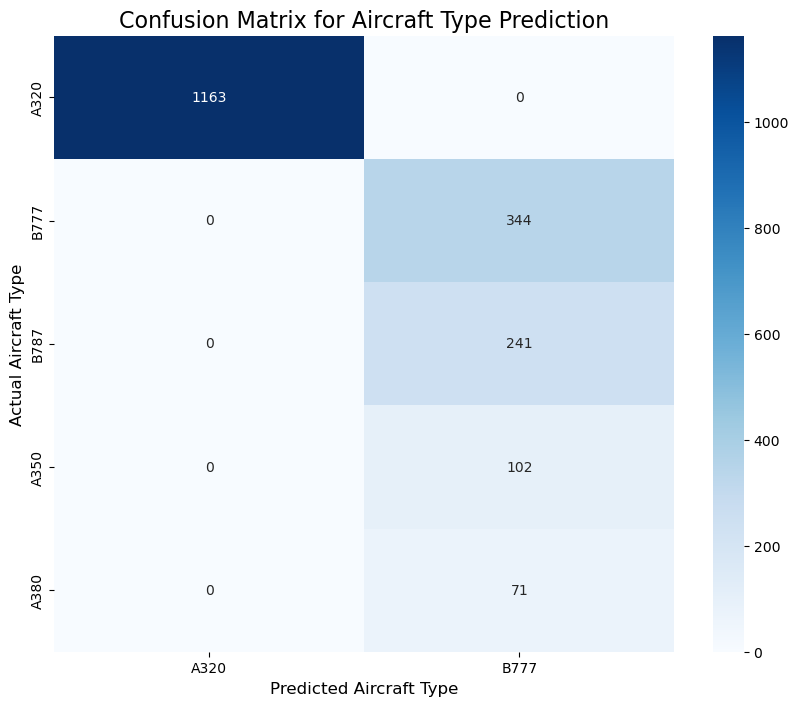

In [1]:
# ===================================================================
# === SCRIPT: COMPLETE CLASSIFICATION & HEATMAP VISUALIZATION =====
# ===================================================================

# === Imports ===
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, dayofweek
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# === Step 1: Create Spark Session ===
spark = SparkSession.builder.appName("FlightPulse-Heatmap").getOrCreate()
print("--- SparkSession Created ---")

# === Step 2: Load and Prepare Base DataFrame ===
df = spark.read.csv("flights.csv", header=True, inferSchema=True)
df_transformed = df.withColumn(
    "flight_date_formatted", 
    to_date(col("FLIGHT_DATE"), "dd-MM-yyyy")
).withColumn(
    "day_of_week",
    dayofweek(col("flight_date_formatted"))
)
print("--- Base DataFrame Prepared ---")

# === Step 3: Feature Engineering ===
label_indexer = StringIndexer(inputCol="AIRCRAFT_TYPE", outputCol="label")
categorical_cols = ["TIME_OF_DAY", "DEPARTURE_STATION_CD", "ARRIVAL_STATION_CD", "HAUL"]
numerical_cols = ["day_of_week"]
indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_index", handleInvalid="keep") for c in categorical_cols]
assembler_inputs = [f"{c}_index" for c in categorical_cols] + numerical_cols
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")
pipeline = Pipeline(stages=[label_indexer] + indexers + [assembler])
ml_ready_data = pipeline.fit(df_transformed).transform(df_transformed)
print("--- Feature Engineering Complete ---")

# === Step 4: Train Model & Get Predictions ===
(training_data, testing_data) = ml_ready_data.randomSplit([0.8, 0.2], seed=42)
lr = LogisticRegression(featuresCol='features', labelCol='label')
lr_model = lr.fit(training_data)
lr_predictions = lr_model.transform(testing_data)
print("--- Model Trained and Predictions Made ---")

# === Step 5: Prepare Data and Create Heatmap ===
# Get the label names (the actual aircraft types) back for our chart.
label_converter = ml_ready_data.select("AIRCRAFT_TYPE", "label").distinct().toPandas()
label_map = dict(zip(label_converter.label, label_converter.AIRCRAFT_TYPE))

# Format the confusion matrix data from Spark into a Pandas DataFrame.
conf_matrix_df = lr_predictions.groupBy("label", "prediction").count().toPandas()
conf_matrix_pivot = conf_matrix_df.pivot(index='label', columns='prediction', values='count').fillna(0)

# Rename the index and columns to use the real aircraft names.
conf_matrix_pivot = conf_matrix_pivot.rename(index=label_map, columns=label_map)

# Create the heatmap.
print("\n--- Generating Confusion Matrix Heatmap ---")
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix_pivot, 
    annot=True,    # Show the numbers on the squares
    fmt='g',       # Display numbers as integers
    cmap='Blues'   # Use a blue color scheme
)
plt.title('Confusion Matrix for Aircraft Type Prediction', fontsize=16)
plt.xlabel('Predicted Aircraft Type', fontsize=12)
plt.ylabel('Actual Aircraft Type', fontsize=12)
plt.show()